# System Risk Exploratory Data Analysis  
**Policy-Driven AI Systems: Online Content Moderation**

This notebook documents exploratory analyses used to diagnose **system-level risks** in automated content moderation models.

- **Origin Risk** — label ambiguity and annotation subjectivity  
- **Propagation Risk** — identity-linked correlations and shortcut learning  
- **Outcome Risk** — unequal error exposure across groups  
- **Governance Risk** — inflated performance under legacy evaluation

Raw datasets are not redistributed in this repository. Users should supply the Civil Comments source data via local paths or an approved storage method.


In [ ]:
!pip install kaggle --quiet


✅ Libraries imported successfully. Environment ready.


### 1.1 Dataset Overview
The Civil Comments dataset contains about 2 million public comments and 14 columns.
No missing values were found, and all numeric toxicity labels range between 0 and 1.
This shows the dataset is complete and ready for cleaning.

The extra metadata columns (e.g., `article_id`, `parent_id`, `publication_id`, `created_date`) are helpful for tracing the origin of comments
but not needed for exploratory analysis, so we’ll drop them in the next step.

Both `text` and `parent_text` contain byte strings (not plain text), which we’ll decode before continuing.


In [ ]:
# ==========================================================
# 1.2 Cleaning and Preparing the Working Dataset (restored)
# ==========================================================

# Decode byte strings in 'text' and 'parent_text'
for col in ['text', 'parent_text']:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Drop only truly non-analytical metadata
drop_cols = ['article_id', 'id', 'parent_id', 'publication_id']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Keep and parse the real created_date if present
if 'created_date' in df.columns:
    df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')

# Reorder major analytical fields
cols = ['text','parent_text','toxicity','severe_toxicity','obscene',
        'threat','insult','identity_attack','sexual_explicit']
df = df[[c for c in cols if c in df.columns] +
        [c for c in df.columns if c not in cols]]

print("✅ Cleaned working dataset restored.")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
df.head()


✅ Cleaned working dataset restored.
Shape: 1,999,514 rows × 10 columns


,text,parent_text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,created_date
0,"btw, Globe, your new comment section is lame. ...",,0.2,0.0,0.0,0.0,0.0,0.0,0.0,NaT
1,If at first you don't succeed...try again: htt...,I get the impression that Boeing is very afra...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT
2,You don't understand what leaking is. By the ...,Here's a vote for Comey to be prosecuting for ...,0.7,0.0,0.0,0.0,0.7,0.0,0.0,NaT
3,duties come before rights.\nthey have a duty t...,"Excuse me, but what religious freedom are you ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT
4,Based upon the activities of the OHA I have al...,Who thought it would be a good idea to put Row...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaT


### 1.2 Cleaning
The working dataset now includes only the columns needed for analysis:
`text`, `parent_text`, and the seven toxicity-related labels.

All metadata fields were dropped since they are not part of the analysis.
The text columns are decoded and human-readable.

This cleaned version will be used for all visualizations and descriptive statistics.


Average score (0–1) for each label:

toxicity           0.102924
insult             0.081138
identity_attack    0.022549
obscene            0.013890
threat             0.009281
sexual_explicit    0.006562
severe_toxicity    0.004581
dtype: float32


/tmp/ipython-input-1744467551.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_means.values, y=label_means.index, palette="viridis")


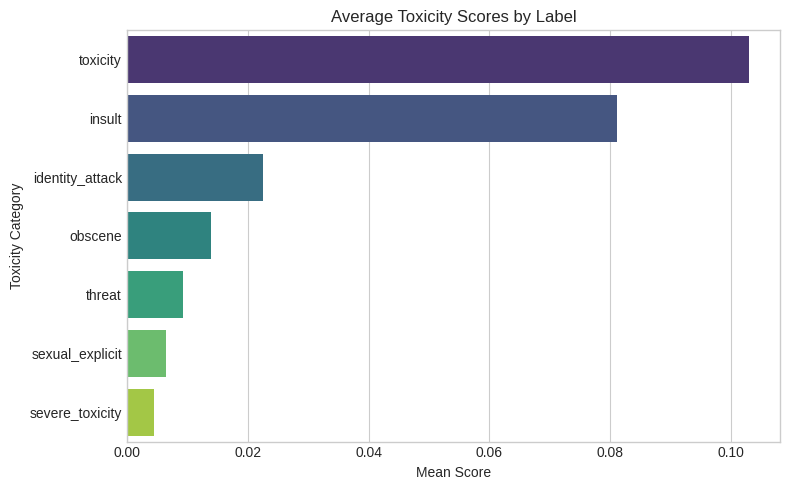

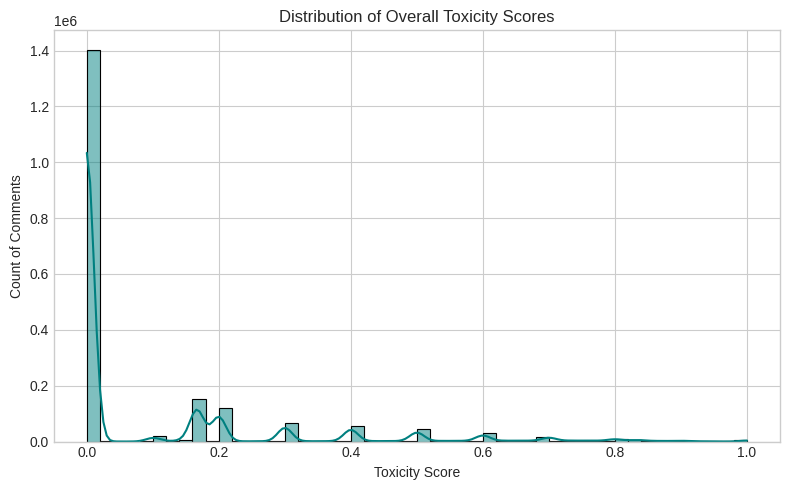

In [ ]:
# ==========================================================
# 2.1 Overview of Label Distributions
# ----------------------------------------------------------
# Let's get a feel for how each toxicity label is distributed.
# We'll:
#   • calculate the average value (mean) for each label
#   • make a simple bar chart to compare overall toxicity rates
#   • plot a histogram for the main "toxicity" column
# ==========================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate mean for each label
label_means = df[['toxicity','severe_toxicity','obscene','threat',
                  'insult','identity_attack','sexual_explicit']].mean().sort_values(ascending=False)

# Display numeric summary
print("Average score (0–1) for each label:\n")
print(label_means)

# --- Bar chart of mean values ---
plt.figure(figsize=(8,5))
sns.barplot(x=label_means.values, y=label_means.index, palette="viridis")
plt.title("Average Toxicity Scores by Label")
plt.xlabel("Mean Score")
plt.ylabel("Toxicity Category")
plt.tight_layout()
plt.show()

# --- Histogram of the main 'toxicity' column ---
plt.figure(figsize=(8,5))
sns.histplot(df['toxicity'], bins=50, kde=True, color="teal")
plt.title("Distribution of Overall Toxicity Scores")
plt.xlabel("Toxicity Score")
plt.ylabel("Count of Comments")
plt.tight_layout()
plt.show()


Correlation matrix:

                 toxicity  severe_toxicity  obscene  threat  insult  \
toxicity             1.00             0.39     0.49    0.29    0.93   
severe_toxicity      0.39             1.00     0.34    0.28    0.33   
obscene              0.49             0.34     1.00    0.09    0.43   
threat               0.29             0.28     0.09    1.00    0.11   
insult               0.93             0.33     0.43    0.11    1.00   
identity_attack      0.45             0.26     0.12    0.15    0.31   
sexual_explicit      0.25             0.20     0.33    0.09    0.15   

                 identity_attack  sexual_explicit  
toxicity                    0.45             0.25  
severe_toxicity             0.26             0.20  
obscene                     0.12             0.33  
threat                      0.15             0.09  
insult                      0.31             0.15  
identity_attack             1.00             0.12  
sexual_explicit             0.12             1

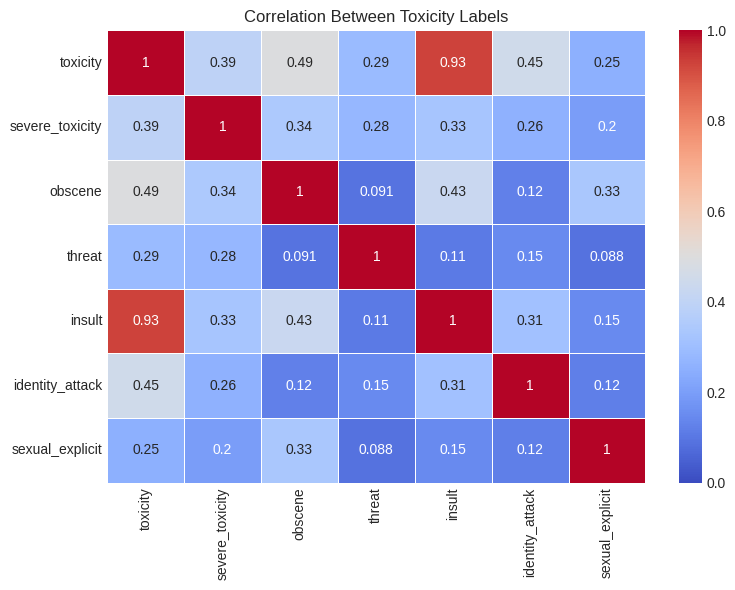

In [ ]:
# ==========================================================
# 2.2 Inter-Label Relationships
# ----------------------------------------------------------
# Let's check how the different toxicity labels relate to each other.
# If two labels are strongly correlated, it means they often appear together.
# This helps us understand overlap and possible redundancy in how raters labeled comments.
# ==========================================================

# Compute the correlation matrix for toxicity labels
label_cols = ['toxicity','severe_toxicity','obscene','threat',
              'insult','identity_attack','sexual_explicit']
corr = df[label_cols].corr()

# Display the numeric matrix first
print("Correlation matrix:\n")
print(corr.round(2))

# --- Heatmap visualization ---
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=0, vmax=1, linewidths=0.5)
plt.title("Correlation Between Toxicity Labels")
plt.tight_layout()
plt.show()


### 2.2 Inter-Label Relationships
The heatmap shows how often the different toxicity labels overlap.
Overall `toxicity` is strongly correlated with `insult` (≈ 0.93) and moderately
with `obscene` (≈ 0.49) and `identity_attack` (≈ 0.45).
This means that when a comment is marked toxic, it is very likely to also be
considered insulting, and sometimes obscene or identity-related.

Labels such as `threat` and `sexual_explicit` show very weak correlations with
the others, suggesting that they represent more specific and independent types
of harmful content.

These relationships help explain how raters may have interpreted the labeling
guidelines: broader categories (toxicity, insult) often co-occur, while narrow
categories (threats, sexual content) appear more selectively.


Summary of comment length:

count    1.999514e+06
mean     2.972535e+02
std      2.691821e+02
min      1.000000e+00
25%      9.400000e+01
50%      2.020000e+02
75%      4.140000e+02
max      1.971000e+03
Name: text_length, dtype: float64


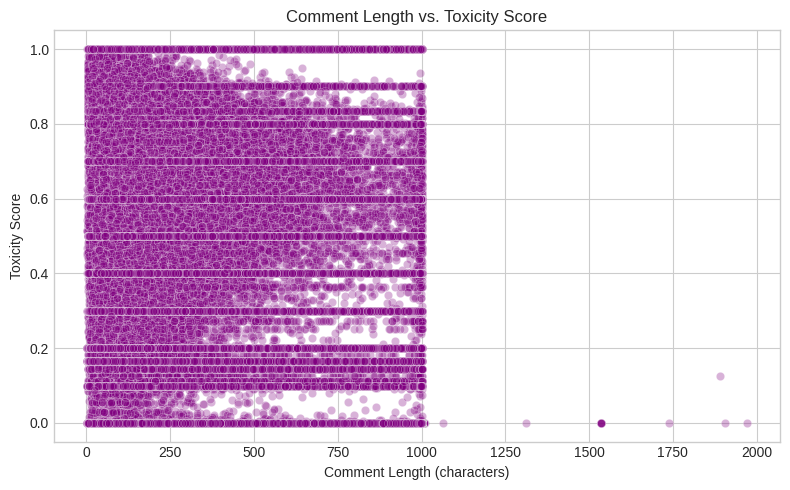

/tmp/ipython-input-2799917365.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pd.qcut(df['text_length'], q=4, duplicates='drop'), y='toxicity', data=df, palette='Purples')


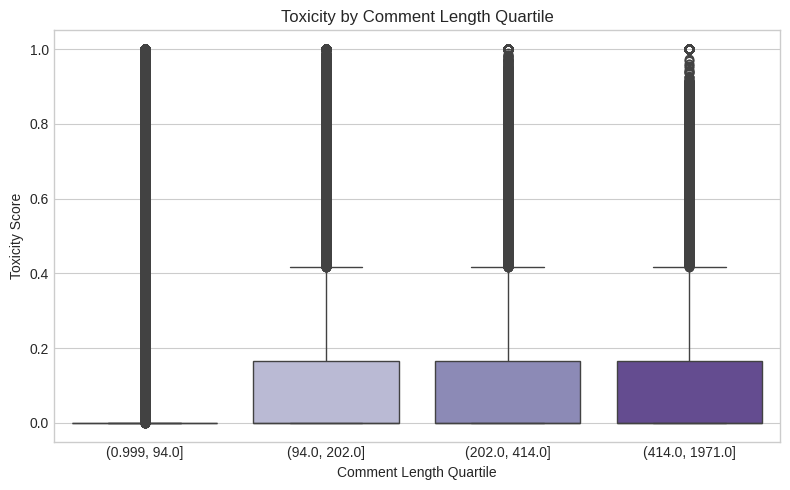

In [ ]:
# ==========================================================
# 2.3 Text Length vs. Toxicity
# ----------------------------------------------------------
# We'll see if longer comments tend to have higher toxicity scores.
# Steps:
#   • Add a column that measures comment length (number of characters)
#   • Look at summary stats for length
#   • Plot length against toxicity to see if there’s any visible trend
# ==========================================================

# Create a new column for text length (number of characters)
df['text_length'] = df['text'].str.len()

# Quick summary stats
print("Summary of comment length:\n")
print(df['text_length'].describe())

# --- Scatterplot of comment length vs toxicity ---
plt.figure(figsize=(8,5))
sns.scatterplot(x='text_length', y='toxicity', data=df, alpha=0.3, color='purple')
plt.title("Comment Length vs. Toxicity Score")
plt.xlabel("Comment Length (characters)")
plt.ylabel("Toxicity Score")
plt.tight_layout()
plt.show()

# --- Boxplot to visualize averages by length quartiles ---
plt.figure(figsize=(8,5))
sns.boxplot(x=pd.qcut(df['text_length'], q=4, duplicates='drop'), y='toxicity', data=df, palette='Purples')
plt.title("Toxicity by Comment Length Quartile")
plt.xlabel("Comment Length Quartile")
plt.ylabel("Toxicity Score")
plt.tight_layout()
plt.show()


### 2.3 Text Length vs. Toxicity
Most comments are short: the median length is about 200 characters,
and only a few reach 1,000–2,000 characters.
The scatterplot shows no strong relationship between comment length
and toxicity. Toxic comments appear across all lengths, but the
majority of longer comments remain non-toxic.

The boxplot confirms this pattern: average toxicity stays roughly
the same across all four length quartiles.
This suggests that comment length does not strongly influence how
raters judged toxicity, there’s no clear “verbosity bias” in this data.


/tmp/ipython-input-826931775.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tox_diff['toxicity_diff'], y=tox_diff.index, palette='mako')


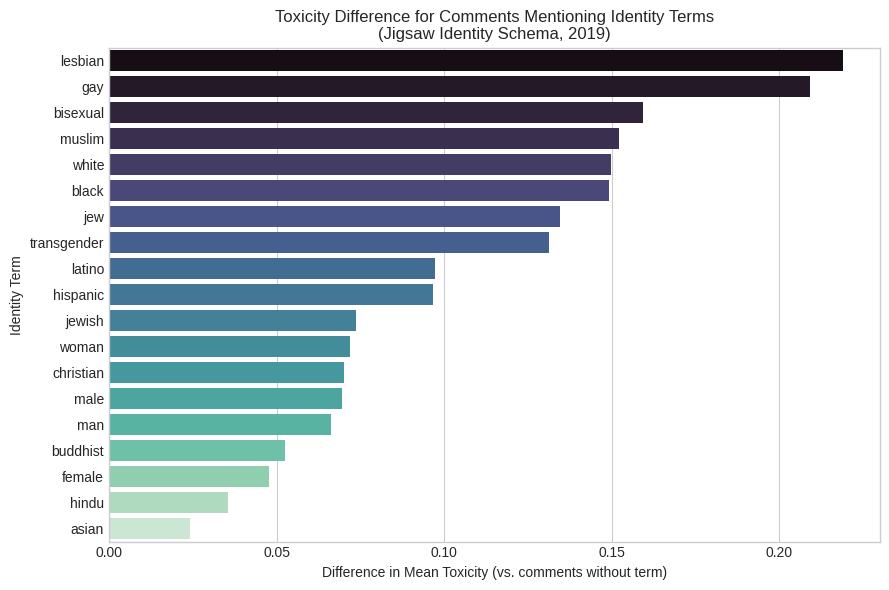

In [ ]:
# ==========================================================
# 2.4 Identity Terms and Fairness Patterns (Academic Version)
# ----------------------------------------------------------
# According to Jigsaw and Conversation AI (2019), identity mentions
# in the Civil Comments dataset are grouped into four main categories:
#   • Gender
#   • Sexual Orientation
#   • Religion
#   • Race / Ethnicity
#
# We'll use representative terms from those categories to check
# whether comments mentioning these identities show different
# average toxicity levels compared to comments that don't.
# ==========================================================

# Identity terms based on Jigsaw's documented schema
identity_terms = [
    # Gender
    'male', 'female', 'man', 'woman', 'transgender',
    # Sexual Orientation
    'gay', 'lesbian', 'bisexual',
    # Religion
    'christian', 'muslim', 'jewish', 'jew', 'buddhist', 'hindu',
    # Race / Ethnicity
    'black', 'white', 'asian', 'latino', 'hispanic'
]

# Create a column for each identity term (True if the term appears)
for term in identity_terms:
    df[term] = df['text'].str.contains(rf'\b{term}\b', case=False, na=False)

# Compare mean toxicity between comments mentioning vs. not mentioning the term
term_toxicity = {}
for term in identity_terms:
    with_term = df.loc[df[term], 'toxicity'].mean()
    without_term = df.loc[~df[term], 'toxicity'].mean()
    term_toxicity[term] = with_term - without_term  # difference in mean toxicity

# Create a DataFrame for easier sorting and plotting
tox_diff = pd.DataFrame.from_dict(term_toxicity, orient='index', columns=['toxicity_diff'])
tox_diff = tox_diff.sort_values(by='toxicity_diff', ascending=False)

# --- Plot the results ---
plt.figure(figsize=(9,6))
sns.barplot(x=tox_diff['toxicity_diff'], y=tox_diff.index, palette='mako')
plt.title("Toxicity Difference for Comments Mentioning Identity Terms\n(Jigsaw Identity Schema, 2019)")
plt.xlabel("Difference in Mean Toxicity (vs. comments without term)")
plt.ylabel("Identity Term")
plt.tight_layout()
plt.show()


### 2.4 Identity Terms and Fairness Patterns
This chart shows the difference in mean toxicity between comments that mention
a given identity term and those that do not.
The terms follow the official schema from Jigsaw and Conversation AI (2019),
which groups identities across gender, sexual orientation, religion, and race.

Comments mentioning LGBTQ+ terms (`lesbian`, `gay`, `bisexual`) show the highest
increase in average toxicity (around +0.20). Mentions of `muslim`, `black`,
and `jew` also appear in more toxic contexts, while terms such as `asian`,
`female`, and `buddhist` show much smaller differences.

These differences do **not necessarily mean** that comments *about* these
groups are more toxic; rather, it suggests that when these words appear,
they are often within discussions that include higher toxicity labels.
This pattern highlights possible *origin risk* — bias introduced by how
raters interpreted context around identity mentions.


/tmp/ipython-input-1588591751.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PMI', y=pmi_df.index, data=pmi_df, palette='flare')
/tmp/ipython-input-1588591751.py:31: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


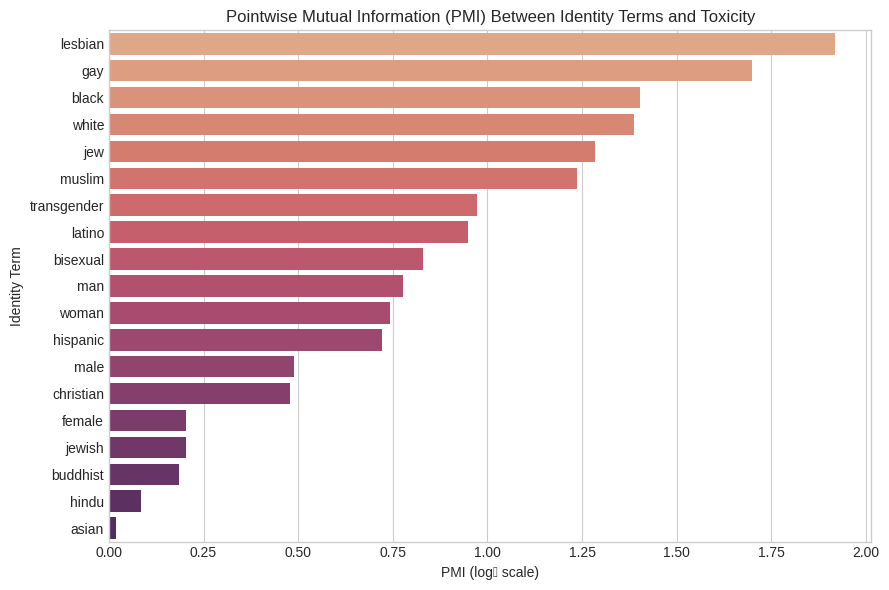

In [ ]:
# ==========================================================
# 2.5 Pointwise Mutual Information (PMI) – Bias Signal
# ----------------------------------------------------------
# PMI measures the association strength between an identity term
# and the label "toxic". Higher PMI = stronger (potentially biased)
# association between the identity term and toxicity.
# ==========================================================

import math

# Define helper function for PMI calculation
def pmi(term, threshold=0.5):
    """Compute Pointwise Mutual Information for one identity term."""
    # probabilities
    p_word = (df['text'].str.contains(rf'\b{term}\b', case=False)).mean()
    p_toxic = (df['toxicity'] > threshold).mean()
    p_joint = ((df['text'].str.contains(rf'\b{term}\b', case=False)) & (df['toxicity'] > threshold)).mean()
    # avoid log of zero
    return math.log2(p_joint / (p_word * p_toxic)) if p_joint > 0 else 0

# Compute PMI for all identity terms
pmi_scores = {term: pmi(term) for term in identity_terms}
pmi_df = pd.DataFrame.from_dict(pmi_scores, orient='index', columns=['PMI']).sort_values(by='PMI', ascending=False)

# --- Plot PMI values ---
plt.figure(figsize=(9,6))
sns.barplot(x='PMI', y=pmi_df.index, data=pmi_df, palette='flare')
plt.title("Pointwise Mutual Information (PMI) Between Identity Terms and Toxicity")
plt.xlabel("PMI (log₂ scale)")
plt.ylabel("Identity Term")
plt.tight_layout()
plt.show()


### 2.5 Pointwise Mutual Information (PMI) – Bias Signal

This chart shows how strongly each identity term is associated with
the label *toxic* compared to its overall frequency in the dataset.
Higher PMI values mean that a term appears disproportionately often
in comments labeled as toxic.

Terms such as **lesbian**, **gay**, **black**, **white**, **jew**, and
**muslim** have the highest PMI scores.
This indicates that these words are statistically more likely to occur
in comments labeled toxic, even though the words themselves are not
inherently harmful.

These associations suggest a form of *propagation risk*: models trained
on this data might learn that certain identity words correlate with
toxicity and could over-flag benign comments containing those terms.
This finding reinforces the importance of bias mitigation during
model development, especially for fairness-sensitive contexts.


Ambiguous proportion: 5.82%


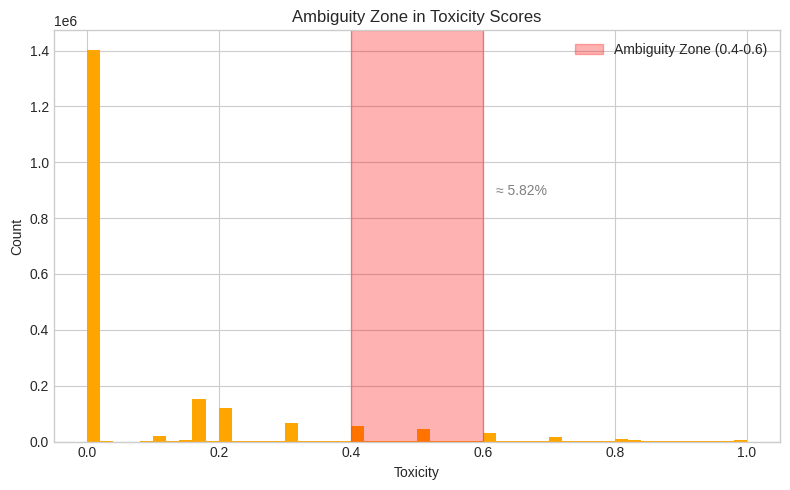

In [ ]:
# ==========================================
# 2.6 Ambiguity and Rater-Uncertainty (Governance Risk)
# ==========================================

import matplotlib.pyplot as plt

# Define ambiguous (uncertain) range
lower, upper = 0.4, 0.6
ambiguous = df[(df['toxicity'] > lower) & (df['toxicity'] < upper)]
ambig_ratio = len(ambiguous) / len(df)

print(f"Ambiguous proportion: {ambig_ratio:.2%}")

# Plot histogram with shaded ambiguity zone
plt.figure(figsize=(8,5))
plt.hist(df['toxicity'], bins=50, color='orange', edgecolor='none')
plt.axvspan(lower, upper, color='red', alpha=0.3, label=f'Ambiguity Zone ({lower}-{upper})')

# Annotate percentage on the plot
plt.text(upper + 0.02, plt.ylim()[1]*0.6, f"≈ {ambig_ratio*100:.2f}%", color='gray', fontsize=10)

# Labels and title
plt.xlabel('Toxicity')
plt.ylabel('Count')
plt.title('Ambiguity Zone in Toxicity Scores')
plt.legend()

# Layout and save
plt.tight_layout()
plt.savefig('fig8_ambiguity_zone.png', dpi=300, bbox_inches='tight')
plt.show()


### 2.6 Ambiguity and Rater-Uncertainty (Governance Risk)

This chart estimates how much uncertainty exists in the dataset by showing how many comments fall within the middle range of toxicity scores (0.4–0.6). About 5.8% of all comments appear in this “ambiguity zone,” meaning raters were divided on whether those comments were toxic or not. Since each score in the Civil Comments dataset represents an average of several human judgments, values near 0.5 likely indicate disagreement or confusion about how to apply moderation rules.

This ambiguous portion of the data is important for studying governance risk. It represents areas where labeling guidelines may have been unclear or subjective, and where small differences in policy interpretation could flip a comment from “acceptable” to “toxic.” Tracking this proportion helps identify the limits of consistency in human moderation and highlights the need for clearer definitions or additional context in future labeling stages.


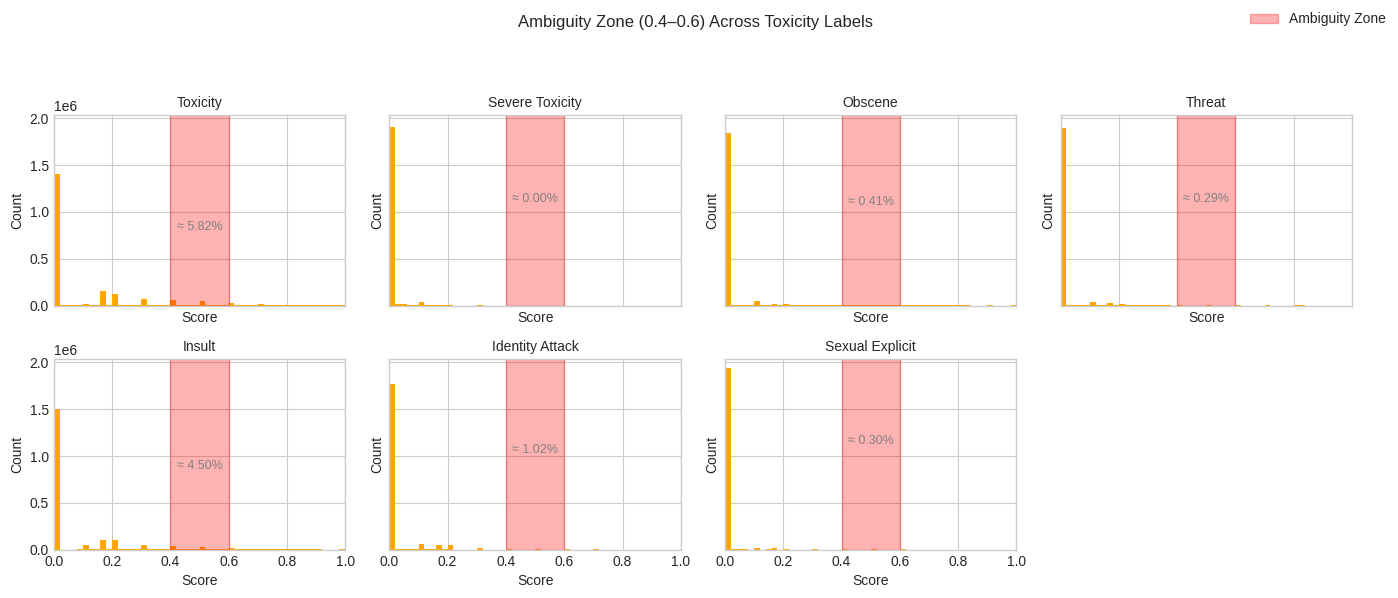


Ambiguity (0.4–0.6) by label:
          label ambiguous_pct
       toxicity         5.82%
         insult         4.50%
identity_attack         1.02%
        obscene         0.41%
sexual_explicit         0.30%
         threat         0.29%
severe_toxicity         0.00%


In [ ]:
# ==========================================
# 2.6 Ambiguity by Label (Small Multiples)
# ==========================================

labels = [
    'toxicity',
    'severe_toxicity',
    'obscene',
    'threat',
    'insult',
    'identity_attack',
    'sexual_explicit'
]

# Ambiguity band (governance-uncertainty window)
lower, upper = 0.4, 0.6
bins = 50

ambig_rows = []

# Create a 2x4 grid (last cell unused)
fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True)
axes = axes.ravel()

for i, col in enumerate(labels):
    ax = axes[i]
    s = df[col].dropna()

    # Compute ambiguous proportion for this label
    ambig_ratio = ((s > lower) & (s < upper)).mean()
    ambig_rows.append({'label': col, 'ambiguous_pct': ambig_ratio * 100})

    # Histogram + shaded band
    counts, edges, _ = ax.hist(s, bins=bins, color='orange', edgecolor='none')
    ax.axvspan(lower, upper, color='red', alpha=0.30, label=f'{lower:.1f}–{upper:.1f}')

    # Annotate % roughly mid-band
    y_annot = counts.max() * 0.60 if counts.size else 0
    ax.text((lower+upper)/2, y_annot, f"≈ {ambig_ratio*100:.2f}%", ha='center', va='center', color='gray', fontsize=9)

    ax.set_title(col.replace('_', ' ').title(), fontsize=10)
    ax.set_xlim(0, 1)

# Hide the unused 8th subplot (if any)
if len(labels) < len(axes):
    axes[-1].axis('off')

# Common labels, legend, layout
fig.suptitle('Ambiguity Zone (0.4–0.6) Across Toxicity Labels', fontsize=12)
for ax in axes:
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')
handles, _ = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Ambiguity Zone'], loc='upper right')

plt.tight_layout(rect=[0, 0, 0.98, 0.92])
plt.savefig('fig9_ambiguity_by_label.png', dpi=300, bbox_inches='tight')
plt.show()

# Print a concise summary table
summary = pd.DataFrame(ambig_rows).sort_values('ambiguous_pct', ascending=False)
print("\nAmbiguity (0.4–0.6) by label:")
print(summary.to_string(index=False, formatters={'ambiguous_pct': '{:.2f}%'.format}))


### 2.6 Ambiguity Across All Toxicity Labels

This set of histograms compares how much disagreement exists across all seven toxicity-related categories. The shaded red area marks the “ambiguity zone,” where average scores fall between 0.4 and 0.6. Comments in this range are the ones raters were most divided on—some likely considered them harmful, while others did not.

The results show that the highest uncertainty appears in the general toxicity (≈5.8%) and insult (≈4.5%) categories, while labels such as threat and sexual_explicit show very little ambiguity. This pattern suggests that raters are most consistent when labeling clearly harmful or explicit content, but less consistent when judging borderline or contextual forms of toxicity, such as insults or tone.

These differences highlight how governance risk varies by label type. Categories with broader definitions of harm, like toxicity and insult, depend more on subjective interpretation, which can lead to inconsistent moderation decisions. Tracking these variations helps identify where clearer labeling rules or context cues are needed to improve rater agreement.


/tmp/ipython-input-424772489.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ambig.values()), y=list(ambig.keys()), palette='flare')


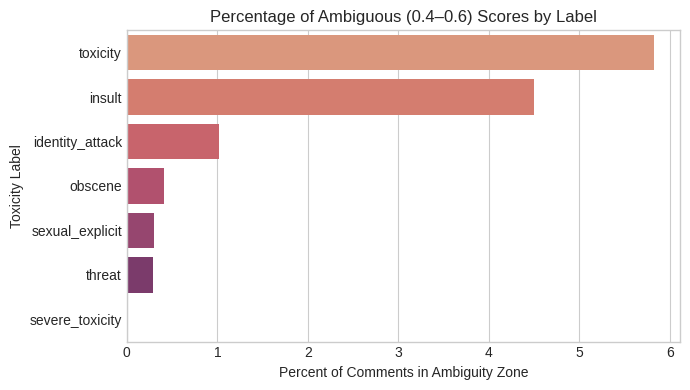

In [ ]:

ambig = {
    'toxicity': 5.82,
    'insult': 4.50,
    'identity_attack': 1.02,
    'obscene': 0.41,
    'sexual_explicit': 0.30,
    'threat': 0.29,
    'severe_toxicity': 0.00
}

plt.figure(figsize=(7,4))
sns.barplot(x=list(ambig.values()), y=list(ambig.keys()), palette='flare')
plt.title("Percentage of Ambiguous (0.4–0.6) Scores by Label")
plt.xlabel("Percent of Comments in Ambiguity Zone")
plt.ylabel("Toxicity Label")
plt.tight_layout()
plt.show()


### 2.6.1 Summary of Ambiguity by Label

This bar chart summarizes the proportion of comments falling in the ambiguous zone (scores between 0.4 and 0.6) for each toxicity label. The results confirm that general toxicity and insult categories have the largest share of uncertain cases—about 5–6% of all comments—while threat, sexual_explicit, and severe_toxicity have almost none.

The pattern suggests that some forms of harmful language are easier for raters to agree on than others. Clear threats or explicit content tend to produce consistent labels, but categories like insult or mild toxicity involve subjective interpretation of tone and intent. By visualizing these differences, this summary figure reinforces the idea that governance risk is not uniform: some moderation categories inherently carry greater ambiguity and require clearer definitions or context to improve labeling consistency.


/tmp/ipython-input-3641207898.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


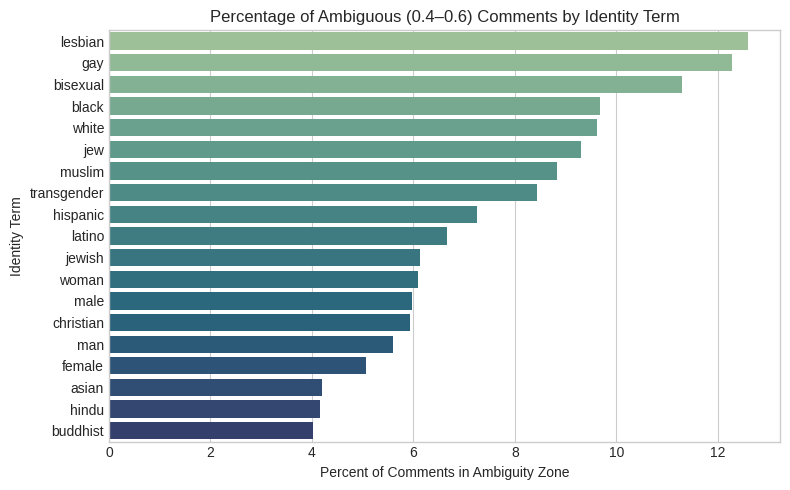

In [ ]:
# ==========================================
# 2.6.2 Ambiguity vs Identity Terms
# ==========================================

# Define the ambiguity range
lower, upper = 0.4, 0.6

# List of identity columns
identity_terms = [
    'male', 'female', 'man', 'woman', 'transgender',
    'gay', 'lesbian', 'bisexual', 'christian', 'muslim',
    'jewish', 'jew', 'buddhist', 'hindu',
    'black', 'white', 'asian', 'latino', 'hispanic'
]

# Compute ambiguity proportion for each identity term
results = []
for col in identity_terms:
    if df[col].dtype == bool or set(df[col].unique()) <= {0, 1, True, False}:
        subset = df[df[col] == True]
        if len(subset) > 0:
            ambig_ratio = ((subset['toxicity'] > lower) & (subset['toxicity'] < upper)).mean() * 100
            results.append({'Identity Term': col, 'Ambiguous %': ambig_ratio})

ambig_identity = pd.DataFrame(results).sort_values('Ambiguous %', ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(
    data=ambig_identity,
    x='Ambiguous %',
    y='Identity Term',
    palette='crest'
)

plt.title('Percentage of Ambiguous (0.4–0.6) Comments by Identity Term')
plt.xlabel('Percent of Comments in Ambiguity Zone')
plt.ylabel('Identity Term')
plt.tight_layout()
plt.show()


### 2.6.2 Ambiguity vs. Identity Terms

This chart shows the percentage of comments containing each identity term that fall within the ambiguous range of toxicity scores (0.4–0.6). Higher percentages mean raters were more divided on whether those comments were toxic. Terms related to sexual orientation and race—such as “lesbian,” “gay,” “bisexual,” and “black”—show the highest ambiguity levels, reaching around 10–13%. This indicates that comments involving these identities are more context-dependent and harder to judge consistently.

Lower ambiguity rates for religious or gender terms suggest clearer or more uniform interpretations among raters. These results highlight governance risk: even when average toxicity remains stable, the uncertainty around identity-related speech reveals areas where moderation policies may lack clarity or consensus. Such insights support the need for updated labeling guidelines and training to ensure fairness in identity-sensitive contexts.


In [ ]:
# ==========================================
# 2.6.2 Annotator Uncertainty - Entropy
# ==========================================

LABEL_COL = "toxicity" if "toxicity" in df.columns else "target"
p = df[LABEL_COL].clip(1e-6, 1-1e-6)

df["entropy_bits"] = -(p*np.log2(p) + (1-p)*np.log2(1-p))
ambig_pct = df[LABEL_COL].between(0.4,0.6).mean()*100
print(f"Ambiguity band (0.4–0.6): {ambig_pct:.2f}%")

plt.figure(figsize=(6,4))
sns.histplot(df["entropy_bits"], bins=40, kde=True, color="tab:blue")
plt.title("Fig 2.6.2 — Annotator Uncertainty (Entropy of Toxicity Fraction)")
plt.xlabel("Entropy (bits)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("figures/02_6_2_entropy_hist.png", dpi=300)
plt.show()
